### Import 

In [5]:
import pandas as pd
from sklearn.preprocessing import Normalizer, PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
plt.rcParams['figure.figsize'] = [12, 8]
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from bokeh.plotting import figure
from bokeh.models import Select
from bokeh.io import output_notebook, show, push_notebook
from bokeh.models import ColumnDataSource, Slider, CustomJS, Div
from sklearn.model_selection import GridSearchCV
from bokeh.layouts import column, row
output_notebook()
import bokeh
import seaborn as sns
from ipywidgets import interact
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from pathlib import Path

Loading BokehJS ...

### Baseline correction  
https://github.com/zmzhang/airPLS

In [6]:
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    E=eye(m,format='csc')
    for i in range(differences):
        E=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*E.T*E))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z


### Dataset 

https://figshare.com/projects/LIBS2022_Quantification_Contest/142250  
https://libs2022.com/

### Read data for training

In [7]:
data_path = dataset_path = Path().absolute().parent / 'data'

In [9]:
data_training = pd.read_csv(data_path / 'train_dataset.csv')

In [10]:
data_training

200  200.020004272461  200.039993286133  200.059997558594  \
0     0.000010          0.001747          0.001477          0.002694   
1     0.002484          0.001943          0.001610          0.002062   
2     0.000230          0.000475          0.000754          0.001994   
3     0.001029          0.000596          0.001769          0.000886   
4    -0.003513          0.001748          0.002183          0.000505   
...        ...               ...               ...               ...   
2095  0.002264          0.002402         -0.000559          0.002850   
2096  0.008210          0.000836          0.000103          0.000765   
2097  0.000226          0.006540          0.000969         -0.000720   
2098  0.000237          0.003592          0.000563          0.000284   
2099  0.002111          0.000887          0.000699          0.002379   

      200.080001831055  200.100006103516  200.119995117188  200.139999389648  \
0             0.001689          0.001828          0.000127         -0.000101   
1            -0.000746          0.001947          0.002961          0.003321   
2             0.000771          0.001478          0.001255          0.001335   
3             0.000491          0.002019          0.000893         -0.001186   
4            -0.000304          0.001544         -0.000112          0.000778   
...                ...               ...               ...               ...   
2095         -0.000560          0.000547         -0.000071          0.000628   
2096          0.000508          0.005778          0.001087          0.000222   
2097          0.002583          0.004462          0.004571          0.006759   
2098          0.000141          0.000787          0.001087          0.002731   
2099          0.000606          0.002534          0.002370          0.001260   

      200.160003662109  200.179992675781  ...  999.919982910156  \
0            -0.000023          0.002150  ...          0.003621   
1            -0.000938          0.000817  ...          0.003975   
2             0.001972          0.001638  ...          0.002733   
3             0.001689          0.002193  ...          0.003059   
4             0.001538          0.000532  ...          0.003133   
...                ...               ...  ...               ...   
2095          0.000101          0.001593  ...          0.002244   
2096          0.008658          0.001648  ...          0.003443   
2097          0.003972         -0.000213  ...          0.004118   
2098          0.000774         -0.000290  ...          0.003966   
2099          0.001267          0.000804  ...          0.002453   

      999.940002441406  999.960021972656  999.97998046875      1000  \
0             0.003494          0.003204         0.003204  0.002824   
1             0.003234          0.001542         0.001542  0.001598   
2             0.002162          0.000860         0.000860  0.001336   
3             0.002907          0.002559         0.002559  0.002987   
4             0.003745          0.005143         0.005143  0.004133   
...                ...               ...              ...       ...   
2095          0.002513          0.003128         0.003128  0.003266   
2096          0.002637          0.000800         0.000800  0.002035   
2097          0.003721          0.002817         0.002817  0.002840   
2098          0.003397          0.002099         0.002099  0.002376   
2099          0.002416          0.002331         0.002331  0.002375   

      1000.02001953125     Cr     Mn      Mo       Ni  
0            -0.000054  0.045  1.960  0.0403  22.5800  
1            -0.000065  0.045  1.960  0.0403  22.5800  
2            -0.000043  0.045  1.960  0.0403  22.5800  
3            -0.000055  0.045  1.960  0.0403  22.5800  
4            -0.000057  0.045  1.960  0.0403  22.5800  
...                ...    ...    ...     ...      ...  
2095         -0.000058  4.510  0.303  3.6000   0.0309  
2096         -0.000156  4.510  0.303  3.6000   0.0309  
2097         -0.000084 

### Group by samples

In [11]:
composition_data = data_training.groupby(['Cr','Mn','Mo','Ni'], as_index=False).count().filter(['Cr', 'Mn', 'Mo','Ni'])
composition_data['Fe'] = 100-composition_data.sum(axis=1)
composition_data['sample'] = range(len(composition_data))
composition_data 

Cr      Mn       Mo       Ni        Fe  sample
0    0.0450  1.9600  0.04030  22.5800  75.37470       0
1    0.0461  2.1200  0.04400  20.9200  76.86990       1
2    0.0545  0.0582  0.01270   3.3900  96.48460       2
3    0.0545  2.0600  0.04920  22.5300  75.30630       3
4    0.0617  0.1520  0.00431   3.6600  96.12199       4
5    0.0941  0.5300  0.01880   3.6800  95.67710       5
6    0.1030  1.8600  0.04720  22.1100  75.87980       6
7    0.1040  1.3700  0.00937   0.0886  98.42803       7
8    0.1050  1.2400  0.00835   0.0777  98.56895       8
9    0.1070  0.1460  0.00634   3.7900  95.95066       9
10   0.1750  1.1300  0.00735   0.2610  98.42665      10
11   0.3810  0.1570  3.62000  17.7400  78.10200      11
12   0.6130  0.1750  3.13000  18.3800  77.70200      12
13   0.7390  0.3410  1.46000   3.9400  93.52000      13
14   0.8500  0.2090  3.11000  18.4100  77.42100      14
15   1.0500  0.6110  0.01000   0.0455  98.28350      15
16   1.3200  0.6070  0.04130   0.0593  97.97240      16
17   1.3300  0.5930  0.04180   0.0634  97.97180      17
18   1.8400  6.5700  0.06100  13.0400  78.48900      18
19   2.6100  1.8500  0.96300   2.0900  92.48700      19
20   3.0700  5.7100  0.18100  14.4200  76.61900      20
21   4.4500  0.2430  3.62000   0.0195  91.66750      21
22   4.5100  0.3030  3.60000   0.0309  91.55610      22
23  12.7100  0.4430  0.40800   1.8400  84.59900      23
24  13.7000  1.2500  0.07190  37.5600  47.41810      24
25  13.8400  1.2500  0.06970  37.7200  47.12030      25
26  14.0300  0.3980  0.62700   4.5100  80.43500      26
27  14.6600  1.3600  0.08070  34.7400  49.15930      27
28  15.3400  0.8110  0.05610  36.8400  46.95290      28
29  15.3700  0.8180  0.05910  36.1400  47.61290      29
30  18.4500  1.0000  0.25600   9.7500  70.54400      30
31  23.2600  0.9640  2.31000  21.6700  51.79600      31
32  23.5900  0.3660  2.85000   6.0800  67.11400      32
33  24.0000  0.3910  2.84000   6.0700  66.69900      33
34  25.0500  0.5990  0.51000   0.1550  73.68600      34
35  25.2000  0.6290  0.48900   0.1810  73.50100      35
36  25.6900  0.4970  0.48300   0.1610  73.16900      36
37  26.4300  1.6100  2.83000   7.0000  62.13000      37
38  26.4700  1.4900  2.98000   6.9100  62.15000      38
39  26.6900  1.7400  2.89000   7.1300  61.55000      39
40  27.1300  0.5230  0.47100   0.1400  71.73600      40
41  27.1600  1.7700  3.00000   7.0100  61.06000      41

In [12]:
data_training_merged = pd.merge(data_training, composition_data, on = ["Cr","Mn","Mo","Ni"], how = "inner")
data_training_merged

200  200.020004272461  200.039993286133  200.059997558594  \
0     0.000010          0.001747          0.001477          0.002694   
1     0.002484          0.001943          0.001610          0.002062   
2     0.000230          0.000475          0.000754          0.001994   
3     0.001029          0.000596          0.001769          0.000886   
4    -0.003513          0.001748          0.002183          0.000505   
...        ...               ...               ...               ...   
2095  0.002264          0.002402         -0.000559          0.002850   
2096  0.008210          0.000836          0.000103          0.000765   
2097  0.000226          0.006540          0.000969         -0.000720   
2098  0.000237          0.003592          0.000563          0.000284   
2099  0.002111          0.000887          0.000699          0.002379   

      200.080001831055  200.100006103516  200.119995117188  200.139999389648  \
0             0.001689          0.001828          0.000127         -0.000101   
1            -0.000746          0.001947          0.002961          0.003321   
2             0.000771          0.001478          0.001255          0.001335   
3             0.000491          0.002019          0.000893         -0.001186   
4            -0.000304          0.001544         -0.000112          0.000778   
...                ...               ...               ...               ...   
2095         -0.000560          0.000547         -0.000071          0.000628   
2096          0.000508          0.005778          0.001087          0.000222   
2097          0.002583          0.004462          0.004571          0.006759   
2098          0.000141          0.000787          0.001087          0.002731   
2099          0.000606          0.002534          0.002370          0.001260   

      200.160003662109  200.179992675781  ...  999.960021972656  \
0            -0.000023          0.002150  ...          0.003204   
1            -0.000938          0.000817  ...          0.001542   
2             0.001972          0.001638  ...          0.000860   
3             0.001689          0.002193  ...          0.002559   
4             0.001538          0.000532  ...          0.005143   
...                ...               ...  ...               ...   
2095          0.000101          0.001593  ...          0.003128   
2096          0.008658          0.001648  ...          0.000800   
2097          0.003972         -0.000213  ...          0.002817   
2098          0.000774         -0.000290  ...          0.002099   
2099          0.001267          0.000804  ...          0.002331   

      999.97998046875      1000  1000.02001953125     Cr     Mn      Mo  \
0            0.003204  0.002824         -0.000054  0.045  1.960  0.0403   
1            0.001542  0.001598         -0.000065  0.045  1.960  0.0403   
2            0.000860  0.001336         -0.000043  0.045  1.960  0.0403   
3            0.002559  0.002987         -0.000055  0.045  1.960  0.0403   
4            0.005143  0.004133         -0.000057  0.045  1.960  0.0403   
...               ...       ...               ...    ...    ...     ...   
2095         0.003128  0.003266         -0.000058  4.510  0.303  3.6000   
2096         0.000800  0.002035         -0.000156  4.510  0.303  3.6000   
2097         0.002817  0.002840         -0.000084  4.510  0.303  3.6000   
2098         0.002099  0.002376         -0.000057  4.510  0.303  3.6000   
2099         0.002331  0.002375         -0.000051  4.510  0.303  3.6000   

           Ni       Fe  sample  
0     22.5800  75.3747       0  
1     22.5800  75.3747       0  
2     22.5800  75.3747       0  
3     22.5800  75.3747       0  
4     22.5800  75.3747       0  
...       ...      ...     ...  
2095   0.0309  91.5561      22  
2096   0.0309  91.5561      22  
2097   0.0309  91.5561      22  
2098   0.0309  91.5561      22  
2099   0.0309  91.5561      22  

[2100 rows x 40008 columns]

### Divide into dependent and independent variables

In [13]:
X_training = data_training.drop(['Cr','Mn','Mo','Ni'], axis = 1)

y_training_Cr = data_training['Cr']
y_training_Mn = data_training['Mn']
y_training_Mo = data_training['Mo']
y_training_Ni = data_training['Ni']

### Plot spectra

In [14]:
def plot_spectra(X, samples, composition_data):
    fig_spectra = figure(toolbar_location="above", x_axis_label=r"$$ \lambda [nm] $$", y_axis_label="Intensity",
                      y_range=(-0.1, 1), x_range=(200, 1000),
                      title="Spectra",width=900, height=700)

    x = X.columns
    y = X.iloc[0,:]
    line_render_data = fig_spectra.line(x, y)


    def update_plot(N):
        signal = X.iloc[int(N),:]
        line_render_data.data_source.data['y'] = signal
        composition = composition_data[composition_data['sample']==samples[int(N)]]
        fig_spectra.title.text = "Sample: "+str(samples[int(N)]) + ", Composition: Cr " + str(composition['Cr'].values[0]) + " Mn "+str(composition['Mn'].values[0]) + " Mo " + str(composition['Mo'].values[0])+ " Ni " + str(composition['Ni'].values[0])
        push_notebook()

    show(column(fig_spectra), notebook_handle=True);
    interact(update_plot, N = (0,X.shape[0]-1));

In [15]:
plot_spectra(X = X_training, samples = data_training_merged['sample'], composition_data = composition_data)

interactive(children=(IntSlider(value=1049, description='N', max=2099), Output()), _dom_classes=('widget-inter…

### Filter noise

In [16]:
def filter_noise(X, treshold):
    X_limited = X.iloc[:,X.columns.astype('float')<220]
    X = X.assign(noise_level = X_limited.apply(max, axis=1))
    return X[X['noise_level'] < treshold].drop(['noise_level'],axis=1)
    

In [17]:
X_filtered = filter_noise(X = X_training, treshold = 0.05)

In [18]:
plot_spectra(X = X_filtered, samples = data_training_merged['sample'], composition_data = composition_data)

interactive(children=(IntSlider(value=973, description='N', max=1946), Output()), _dom_classes=('widget-intera…

### Baseline corrrection

In [19]:
def correct_baseline(X):
    return X.apply(lambda row : row-airPLS(row), axis = 1)

In [20]:
X_baseline_corrected = correct_baseline(X_filtered)

In [21]:
plot_spectra(X = X_baseline_corrected, samples = data_training_merged['sample'], composition_data = composition_data)

interactive(children=(IntSlider(value=973, description='N', max=1946), Output()), _dom_classes=('widget-intera…

### Average 3 columns

In [22]:
def average_columns(X, number_of_columns = 3):
    X_avg = X.groupby(by=np.arange(X.shape[1])//3, axis=1).mean()
    X_avg.columns = [np.mean(val) for val in X.columns.astype('float').groupby(np.arange(X.shape[1])//3).values()]
    return X_avg

In [23]:
X_avg = average_columns(X_filtered)

In [24]:
plot_spectra(X = X_avg,  samples = data_training_merged['sample'], composition_data = composition_data)

interactive(children=(IntSlider(value=973, description='N', max=1946), Output()), _dom_classes=('widget-intera…

### Limit wavelength

In [25]:
def limit_wavelength(X,w_min = 225, w_max = 940):
    X_limited = X.loc[:,(X.columns.astype('float')>w_min) & (X.columns.astype('float')<w_max)]
    return X_limited

### Filter lines with highest variance  
amount - number of lines to be filtered

In [26]:
def select_wavelengts_with_big_variance(X, amount):
    return X.reindex(sorted(X[X.var().nlargest(amount).index]), axis=1)

### Update dependent variable

In [27]:
def update_dependent_variable(X, data_training):
    y_Cr = data_training[data_training.index.isin(X.index)]['Cr']
    y_Mn = data_training[data_training.index.isin(X.index)]['Mn']
    y_Mo = data_training[data_training.index.isin(X.index)]['Mo']
    y_Ni = data_training[data_training.index.isin(X.index)]['Ni']
    return y_Cr, y_Mn, y_Mo, y_Ni

### Correlation of between wavlength and Cr, Mn, Mo, Ni content

In [28]:
def correlation(X, y_Cr, y_Mn, y_Mo, y_Ni):
    data_corr_Cr = []
    data_corr_Mn = []
    data_corr_Mo = []
    data_corr_Ni = []
    
    for wavelength in X.columns:
        data_corr_Cr.append(np.corrcoef(y_Cr, X[wavelength])[0,1])
        data_corr_Mn.append(np.corrcoef(y_Mn, X[wavelength])[0,1])
        data_corr_Mo.append(np.corrcoef(y_Mo, X[wavelength])[0,1])
        data_corr_Ni.append(np.corrcoef(y_Ni, X[wavelength])[0,1])
    
    return pd.DataFrame({'Cr': data_corr_Cr, 'Mn': data_corr_Mn, 'Mo': data_corr_Mo, 'Ni': data_corr_Ni}, index = X.columns)

### Filtering lines with higest correlation:  
- select wavelengts for given element where correlation is greater than 0.7 and for other elements less than 0.5

In [29]:
def filter_lines_with_best_correlation(X, element, cor_threshold, y_Cr, y_Mn, y_Mo, y_Ni):
    data_corr=correlation(X, y_Cr, y_Mn, y_Mo, y_Ni)
    elements = {'Cr', 'Mn', 'Mo', 'Ni'}
    elements.remove(element)
    return X[data_corr.loc[(data_corr[element] >= cor_threshold) & (data_corr[list(elements)[0]] < 0.5) & (data_corr[list(elements)[1]] < 0.5) & (data_corr[list(elements)[2]] < 0.5)].index]    

# TEST - XGBRegressor

### Selecting lines from data with noise spectra filtered out

In [30]:
def preprocessed_data(X, element='Mn'):
    X_filtered = filter_noise(X = X_training, treshold = 0.05)
    
    X_selected = select_wavelengts_with_big_variance(X_filtered, 500)
    
    y_Cr, y_Mn, y_Mo, y_Ni = update_dependent_variable(X_selected, data_training)
    
    X_filtered_lines = filter_lines_with_best_correlation(X_selected, element, 0.5, y_Cr, y_Mn, y_Mo, y_Ni)
    y = {'Cr': y_Cr, 'Mn': y_Mn, 'Mo': y_Mo, 'Ni': y_Ni}
    
    X_train, X_test, y_train, y_test = train_test_split(X_filtered_lines, y[element], test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [31]:
def tune_model(X_train, y_train):
    xgb = XGBRegressor()
    
    parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}
    
    xgb_grid = GridSearchCV(xgb,
                       parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)
    
    xgb_grid.fit(X_train, y_train)
    
    print('Best score:', xgb_grid.best_score_)
    print('Best parameters:', xgb_grid.best_params_)
    
    return xgb_grid.best_estimator_

Cr
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.813690971703503
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



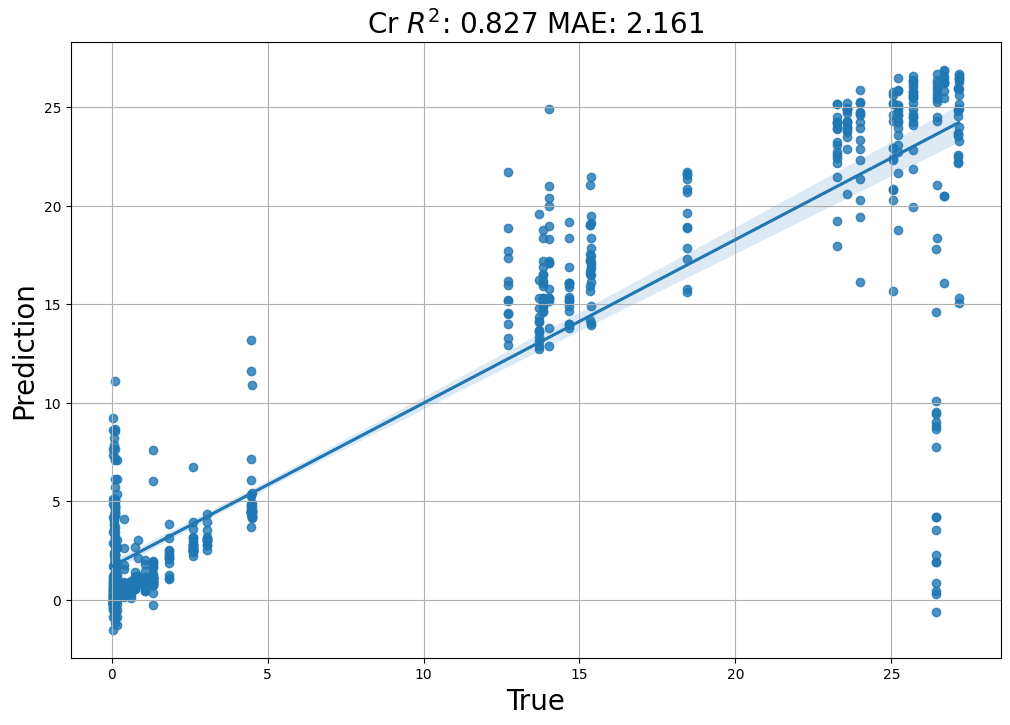

Mn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.8908680607554693
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



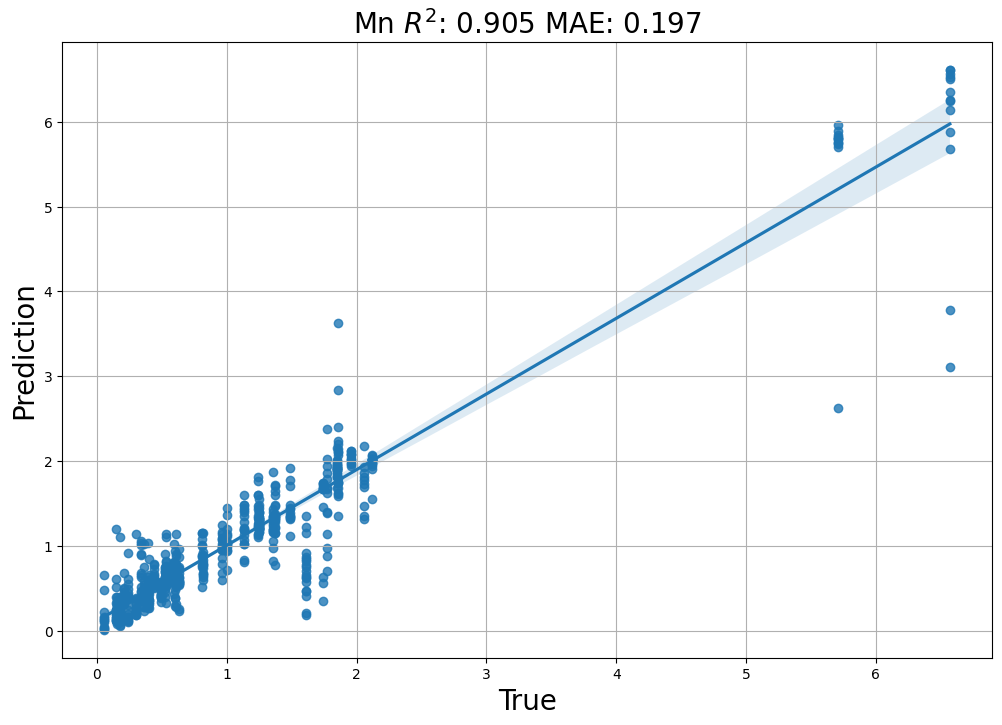

Ni
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.932886612454146
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



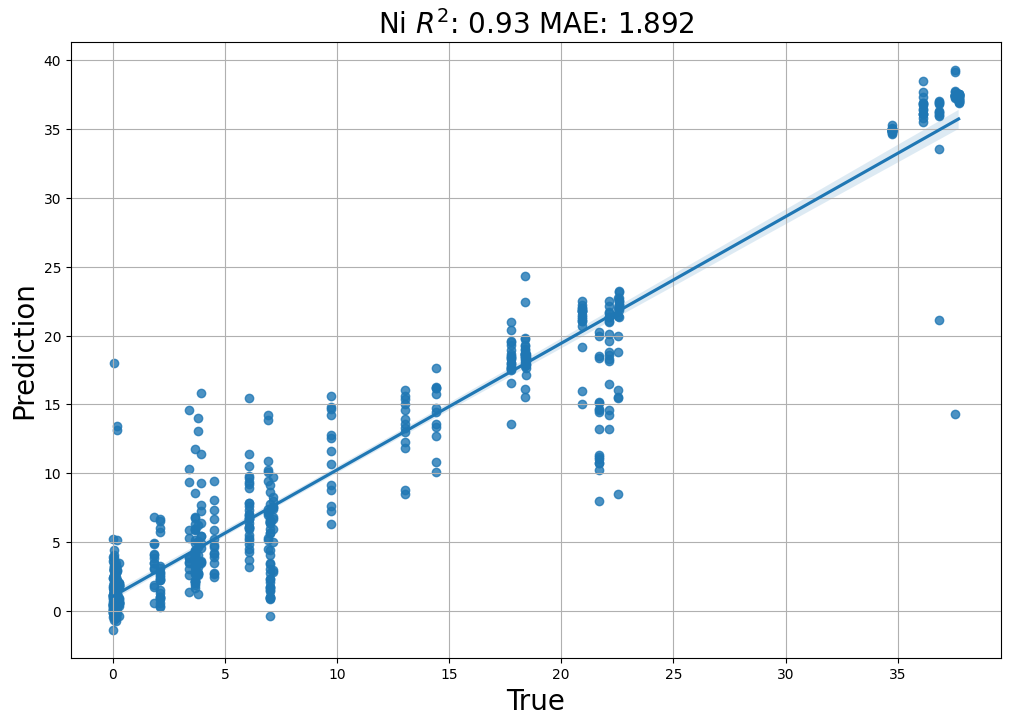

In [32]:
report_df = pd.DataFrame() 
for element in ['Cr', 'Mn', 'Ni']:
    print(element)
    X_train, X_test, y_train, y_test = preprocessed_data(X_training, element=element)
    xgb_tuned_model = tune_model(X_train, y_train)
    y_pred = xgb_tuned_model.predict(X_test)
    x = np.array(y_test)
    y = np.array(y_pred)
    print()
    r2 = np.round(r2_score(y_test, y_pred),3)
    mae = np.round(mean_absolute_error(y_test, y_pred),3)
    report_df[element] = [r2, mae]
    reg_plot = sns.regplot(x=x,y=y,ci=95);
    reg_plot.set_xlabel('True', fontsize = 20)
    reg_plot.set_ylabel('Prediction', fontsize = 20)
    reg_plot.set_title(element+r' $R^{2}$: '+str(r2)+ ' MAE: '+ str(mae),fontsize = 20)
    reg_plot.grid()
    plt.show();

In [33]:
report_df['score'] = ['R2','MAE']
report_df.set_index('score')

Cr     Mn     Ni
score                     
R2     0.827  0.905  0.930
MAE    2.161  0.197  1.892

### PCA 

In [34]:
def preprocessed_data_pca(X, data_training, element='Mn'):
    X_filtered = filter_noise(X = X_training, treshold = 0.05)
    X_avg_limited = limit_wavelength(X_filtered, w_min = 225, w_max = 940)
    X_baseline_corrected = correct_baseline(X_avg_limited)
    y_Cr, y_Mn, y_Mo, y_Ni = update_dependent_variable(X_baseline_corrected, data_training)
    y = {'Cr': y_Cr, 'Mn': y_Mn, 'Mo': y_Mo, 'Ni': y_Ni}
    
    pca = PCA(n_components = 20)
    X_normalized = Normalizer(norm='l2').fit_transform(X_baseline_corrected)
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y[element], test_size=0.33, random_state=42)
    
    pca.fit(X_train)
    
    projected_train = pca.transform(X_train)
    
    return projected_train, y_train, pca, X_test, y_test

Cr
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.9232886959977631
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



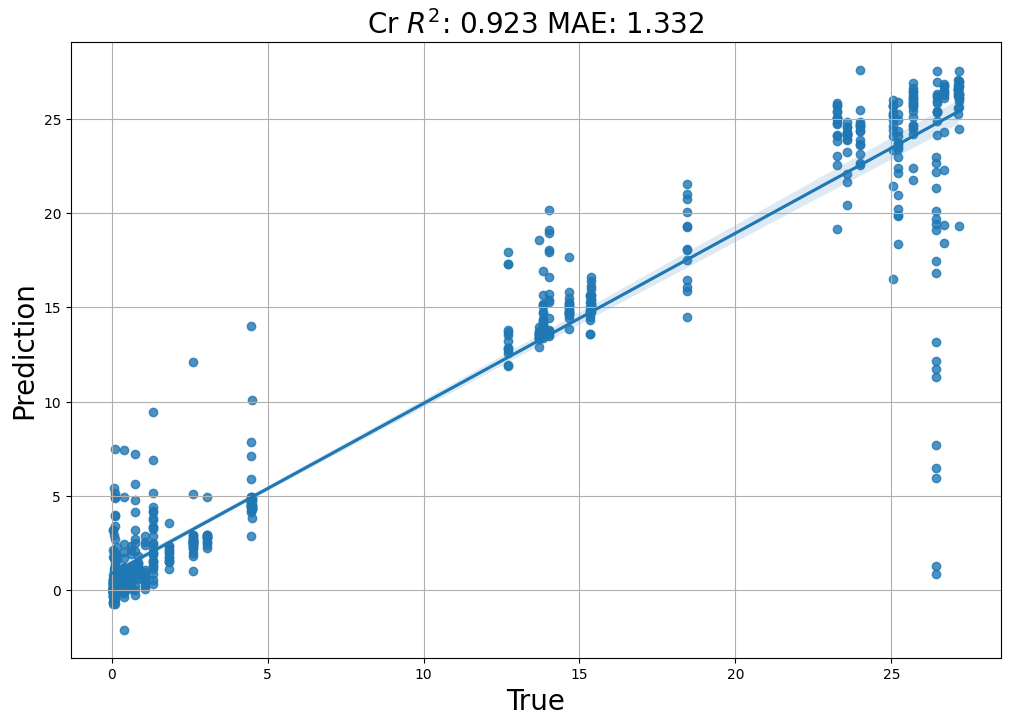

Mn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.9258573750756718
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



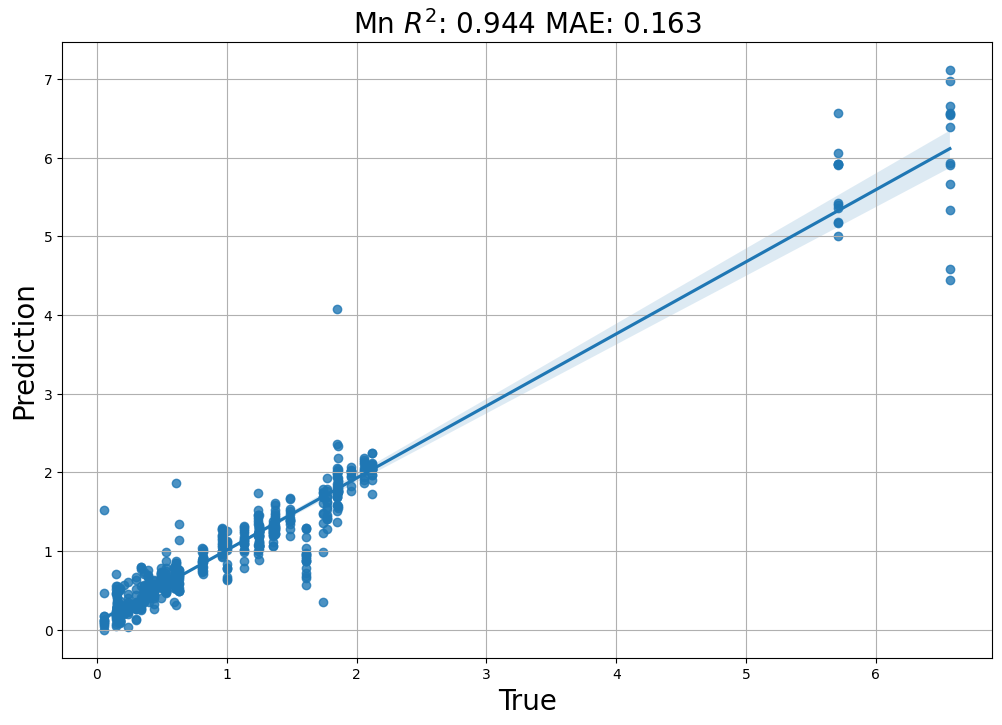

Mo
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.8336034364922911
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



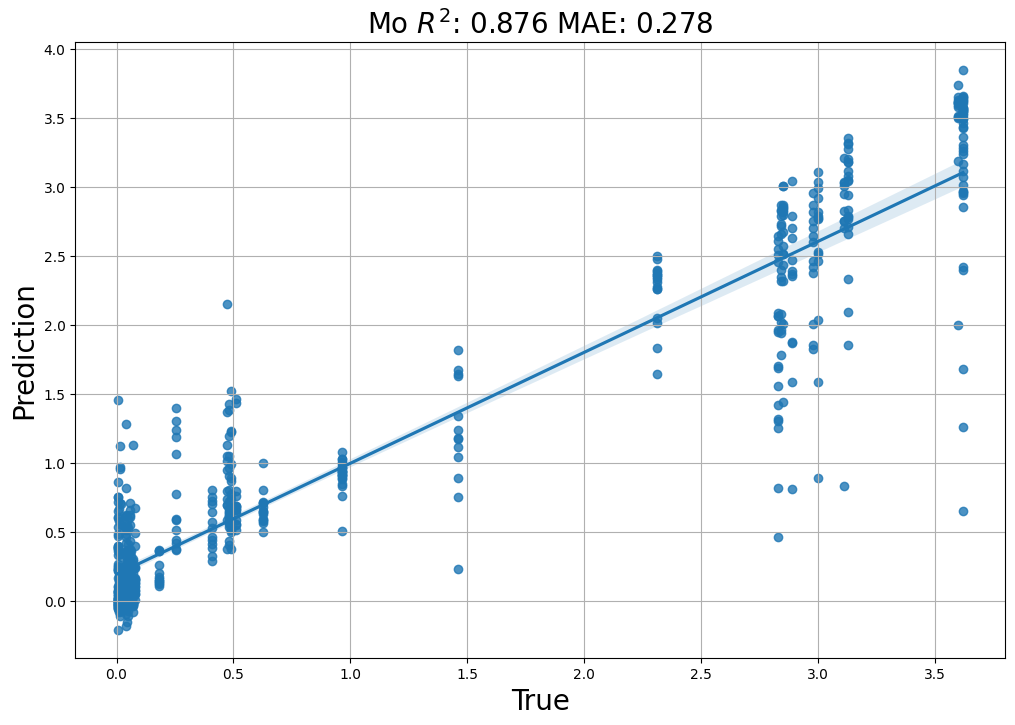

Ni
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.9400119490826043
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}



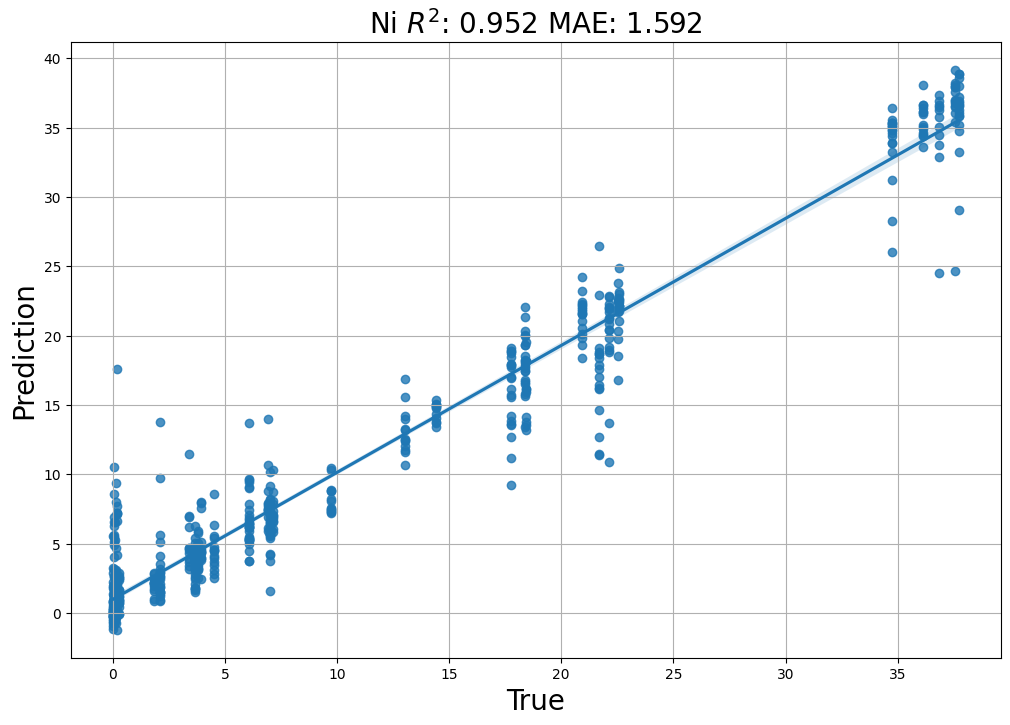

In [35]:
report_df_pca = pd.DataFrame() 
for element in ['Cr', 'Mn', 'Mo' ,'Ni']:
    print(element)
    
    projected_train, y_train, pca, X_test, y_test = preprocessed_data_pca(X = X_training, data_training = data_training, element = element)
    xgb_tuned_model = tune_model(projected_train, y_train)
    
    projected_test = pca.transform(X_test)
    y_pred = xgb_tuned_model.predict(projected_test)
    x = np.array(y_test)
    y = np.array(y_pred)
    
    print()
    r2 = np.round(r2_score(y_test, y_pred),3)
    mae = np.round(mean_absolute_error(y_test, y_pred),3)
    report_df_pca[element] = [r2, mae]
    reg_plot = sns.regplot(x=x,y=y,ci=95);
    reg_plot.set_xlabel('True', fontsize = 20)
    reg_plot.set_ylabel('Prediction', fontsize = 20)
    reg_plot.set_title(element + r' $R^{2}$: ' + str(r2) + ' MAE: ' + str(mae), fontsize = 20)
    reg_plot.grid()
    plt.show();

### PCA 

In [36]:
report_df_pca['score'] = ['R2','MAE']
report_df_pca.set_index('score')

Cr     Mn     Mo     Ni
score                            
R2     0.923  0.944  0.876  0.952
MAE    1.332  0.163  0.278  1.592

### Line selection

In [37]:
report_df.set_index('score')

Cr     Mn     Ni
score                     
R2     0.827  0.905  0.930
MAE    2.161  0.197  1.892